In [2]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import numpy as np
import matplotlib.pyplot as plt
import os
#import torch.nn.functional as F
os.environ["KERAS_BACKEND"] = "tensorflow"
import numpy as np
import tensorflow as tf
import keras
from keras import ops
from keras import layers

### Useful Functions

In [3]:
def ax_standard(ax):

    ax.grid(True, alpha=0.5)
    ax.set_xlabel("Epoch")

def plot_results(history):

    line_color = "#f07167"

    fig, ax = plt.subplots(1, 3, figsize=(15, 5))
    fig.tight_layout(pad=5)

    ax[0].plot(history["loss"], color = line_color)
    ax_standard(ax[0])
    ax[0].set_ylabel("Total Loss")


    ax[1].plot(history["kl_loss"], color = line_color)
    ax_standard(ax[1])
    ax[1].set_ylabel("KL Loss")


    ax[2].plot(history["reconstruction_loss"], color = line_color)
    ax_standard(ax[2])
    ax[2].set_ylabel("Reconstruction Loss")

In [4]:
def plot_training_vs_validation_loss(history):
    """
    Plots the total loss, reconstruction loss, and KL divergence loss
    for both training and validation.

    Parameters:
    history: Keras history object containing training and validation loss values per epoch.
    """
    plt.figure(figsize=(10, 5))

    # Plot total loss
   # plt.plot(history.history["loss"], label="Train Loss", color="#545f66")
   # plt.plot(history.history["val_loss"], label="Validation Loss", color="#829399", linestyle="dashed")

    # Plot reconstruction loss
    plt.plot(history.history["reconstruction_loss"], label="Train Reconstruction Loss", color="#8BE4CB")
    #plt.plot(history.history["val_reconstruction_loss"], label="Validation Reconstruction Loss", color="#DAFA9E", linestyle="dashed")
    plt.xlabel("Epochs")
    plt.ylabel("Loss Value")
    plt.title("Training vs. Validation Reconstruction Loss")
    plt.legend()
    plt.grid(True)
    plt.show()
    # Plot KL loss
    plt.plot(history.history["loss"], label="Total Loss", color="#b1cc74")
    #plt.plot(history.history["val_kl_loss"], label="Validation KL Loss", color="#DAFA9E", linestyle="dashed")

    plt.xlabel("Epochs")
    plt.ylabel("Loss Value")
    plt.title("Training vs. Validation Kl_loss")
    plt.legend()
    plt.grid(True)
    plt.show()

    plt.plot(history.history["kl_loss"], label="KL Loss", color="#b1cc74")
    #plt.plot(history.history["val_kl_loss"], label="Validation KL Loss", color="#DAFA9E", linestyle="dashed")

    plt.xlabel("Epochs")
    plt.ylabel("Loss Value")
    plt.title("Training vs. Validation Kl_loss")
    plt.legend()
    plt.grid(True)
    plt.show()

# Example usage (after training the VAE model)
# plot_training_vs_validation_loss(vae.history)  # Uncomment this after training is completed


In [5]:
latent_dim = 15

### Paper Immplementation

In [6]:
class Sampling(layers.Layer):
    """Uses (z_mean, z_log_var) to sample z, the vector encoding a digit."""

    def __init__(self, **kwargs):
        super().__init__(**kwargs)
        #self.seed_generator = keras.random.SeedGenerator(3718)

    def call(self, inputs):
        z_mean, z_log_var = inputs
        batch = ops.shape(z_mean)[0]
        time_dim = ops.shape(z_mean)[1]
        dim = ops.shape(z_mean)[2]
        epsilon = tf.keras.backend.random_normal(shape=(batch,time_dim, dim)) #batch, time steps, latent dim
        return z_mean + tf.exp(0.5 * z_log_var) * epsilon

class Sampling_t1(layers.Layer):
      def __init__(self, **kwargs):
        super().__init__(**kwargs)
        #self.seed_generator = keras.random.SeedGenerator(3718)

      def call(self, inputs):
          z_mean, z_log_var = inputs
          batch = ops.shape(z_mean)[0]
          #time_dim = ops.shape(z_mean)[1]
          dim = ops.shape(z_mean)[1]
          epsilon = tf.keras.backend.random_normal(shape=(batch, dim)) #batch,  latent dim
          return z_mean + tf.exp(0.5 * z_log_var) * epsilon
#dynamically for shape
class Sampling(layers.Layer):
    def call(self, inputs):
        z_mean, z_log_var = inputs
        epsilon = tf.random.normal(shape=tf.shape(z_mean))
        return z_mean + tf.exp(0.5 * z_log_var) * epsilon


In [7]:

import numpy as np
import tensorflow as tf

# Generate synthetic sine wave sequences
def generate_sine_data(num_samples=1000, sequence_length=200, noise_level=0.1):
    """
    Generate sine wave sequences with slight variations.
    num_samples: Number of sequences.
    sequence_length: Number of time steps per sequence.
    noise_level: Amplitude of added random noise.
    Returns: (num_samples, sequence_length, 1) shape dataset
    """
    X = []
    for _ in range(num_samples):
        freq = np.random.uniform(0.1, 0.5)  # Random frequency
        phase = np.random.uniform(0, np.pi)  # Random phase shift
        sequence = np.sin(np.linspace(0, 2 * np.pi * freq, sequence_length) + phase)
        sequence += np.random.normal(0, noise_level, sequence_length)  # Add noise
        X.append(sequence)

    X = np.array(X).reshape(num_samples, sequence_length, 1)  # Reshape for LSTM input
    return X

# Generate data
X_train = generate_sine_data(num_samples=1000)
X_val = generate_sine_data(num_samples=200)

# Convert to TensorFlow dataset
train_dataset = tf.data.Dataset.from_tensor_slices(X_train).batch(32)
val_dataset = tf.data.Dataset.from_tensor_slices(X_val).batch(32)

print("Training Data Shape:", X_train.shape)  # (1000, 20, 1)
print("Validation Data Shape:", X_val.shape)  # (200, 20, 1)


Training Data Shape: (1000, 200, 1)
Validation Data Shape: (200, 200, 1)


In [8]:
latent_dim = 15

In [9]:
class LatentDynamics(layers.Layer):
    def __init__(self, latent_dim, **kwargs):
        super().__init__(**kwargs)
        self.latent_dim = latent_dim

        # Trainable transition matrix A
        self.A_diag = self.add_weight(
            name='A_diag',
            shape=(latent_dim,),
            initializer=tf.keras.initializers.Ones(),  #
            trainable=True
        )


        # Trainable covariance matrix
        self.log_cov_diag = self.add_weight(
    name='log_cov_diag',
    shape=(latent_dim,),
    initializer=tf.keras.initializers.Zeros(),  # start with log(1) = 0
    trainable=True
        )




    def call(self, inputs=None):  # Added proper method signature
        cov_diag = tf.exp(self.log_cov_diag)
        return self.A_diag, cov_diag



In [10]:
A , cov = LatentDynamics(latent_dim)()

In [11]:
import random

In [12]:
def time_interval():

  prob = random.random()
  if prob < 0.8: #time interval [1,10] with prob 0.8
    t2 = random.randint(10,199) # max time interval is 10, so if t2 < 10 t1 will be negative if dt = 10
    t1 = random.randint(t2-10,t2-1)
  else: #time interval [1,120] with prob 0.2
    t2 = random.randint(120,199)
    t1 = random.randint(t2-120,t2-1)
    print(t1)
  return t1, t2


In [13]:

encoder_inputs = keras.Input(shape = (200,1))
bt = layers.LSTM(64, return_sequences = True)(encoder_inputs)
bt = layers.LSTM(32, return_sequences = True, name = 'bt')(bt) # (time, 32)
#TODO: Implement a DENSE layer to get bt instead of assuming x is bt
#belief state
# This is Pb at all times, use the time index to get Pbt1 and Pbt2
z_mean = layers.Dense(latent_dim, name = 'z_mean_t')(bt) # (time, latentDim) (20,15)
z_log_var = layers.Dense(latent_dim, name = 'z_log_var_t')(bt)

#zt2, this will directly be used in the decoder, no t2 entire thing can be passed into decoder
zt = Sampling()([z_mean, z_log_var]) #(time , latent dim samples)

encoder = keras.Model(encoder_inputs, [z_mean, z_log_var, zt, bt ], name="encoder")
encoder.summary()



Model: "encoder"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 200, 1)    │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm (LSTM)         │ (None, 200, 64)   │     16,896 │ input_layer[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bt (LSTM)           │ (None, 200, 32)   │     12,416 │ lstm[0][0]        │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ z_mean_t (Dense)    │ (None, 200, 15)   │        495 │ bt[0][0]          │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ z_log_var_t (Dense) │ (None, 200, 15)   │        495 │ bt[0][0]          │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ sampling (Sampling) │ (None, 200, 15)   │          0 │ z_mean_t[0][0],   │
│                     │                   │            │ z_log_var_t[0][0] │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 30,302 (118.37 KB)

 Trainable params: 30,302 (118.37 KB)

 Non-trainable params: 0 (0.00 B)

In [14]:

latent_inputs = keras.Input(shape=(latent_dim,))
x = layers.Dense(32, activation="relu")(latent_inputs)
x = layers.Dense(64, activation="relu")(x)
decoder_outputs = layers.Dense(1, activation="sigmoid")(x)  # Predict just x_{t2}

decoder = keras.Model(latent_inputs, decoder_outputs, name="decoder")
decoder.summary()

Model: "decoder"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 15)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 32)             │           512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 64)             │         2,112 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,689 (10.50 KB)

 Trainable params: 2,689 (10.50 KB)

 Non-trainable params: 0 (0.00 B)

In [15]:
smoothing_input = keras.Input(shape = (latent_dim+32+32 +1,)) #latent_dim + bt1+ bt2 + time interval
qs_mean = layers.Dense(latent_dim, name = 'qs_mean_t1')(smoothing_input) # (latentDim) (15)
qs_log_var = layers.Dense(latent_dim, name = 'qs_log_var_t1')(smoothing_input)

zt1 = Sampling()([qs_mean, qs_log_var]) #( latent dim samples)
smoothing = keras.Model(smoothing_input,[zt1,qs_mean,qs_log_var], name = "smoothing")
smoothing.summary()

Model: "smoothing"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_2       │ (None, 80)        │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ qs_mean_t1 (Dense)  │ (None, 15)        │      1,215 │ input_layer_2[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ qs_log_var_t1       │ (None, 15)        │      1,215 │ input_layer_2[0]… │
│ (Dense)             │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ sampling_1          │ (None, 15)        │          0 │ qs_mean_t1[0][0], │
│ (Sampling)          │                   │            │ qs_log_var_t1[0]… │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 2,430 (9.49 KB)

 Trainable params: 2,430 (9.49 KB)

 Non-trainable params: 0 (0.00 B)

In [16]:
transition_input = keras.Input(shape = (latent_dim + 1,)) #latent dim + time interval
pt_mean = layers.Dense(latent_dim, name = 'pt_mean_t1')(transition_input) # (latentDim) (15)
pt_log_var = layers.Dense(latent_dim, name = 'pt_log_var_t1')(transition_input)

transition = keras.Model(transition_input,[pt_mean,pt_log_var], name = "transition_dense")
transition.summary()

Model: "transition_dense"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_3       │ (None, 16)        │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pt_mean_t1 (Dense)  │ (None, 15)        │        255 │ input_layer_3[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pt_log_var_t1       │ (None, 15)        │        255 │ input_layer_3[0]… │
│ (Dense)             │                   │            │                   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 510 (1.99 KB)

 Trainable params: 510 (1.99 KB)

 Non-trainable params: 0 (0.00 B)

In [17]:
def log_normal_pdf(x, mean, logvar):
  return - 0.5 *(
      tf.reduce_sum(tf.math.log(2. * np.pi) + logvar + tf.square(x - mean)/ tf.exp(logvar), axis = -1)
  )

def A_poly(A, power):
    r""""
    Returns a decresing polynomial in powers of A.
    Ex: For power = 3, returns A^3 + A^2 + A + 1
    """
    if power == 0: return 1
    return pow(A,power) + A_poly(A, power-1)


In [29]:
def get_beta_linear(step, warmup_steps, beta_max=4.0):
    return tf.minimum(beta_max, beta_max * (step / tf.cast(warmup_steps, tf.float32)))

def get_beta_cyclic(step, warmup_steps, beta_max=4.0):
    cycle_pos = tf.math.floormod(step, warmup_steps)
    return beta_max * (tf.cast(cycle_pos, tf.float32) / warmup_steps)



In [30]:
class VAE(keras.Model):
    def __init__(self, encoder, decoder, smoothing, transition, latent_dim, transition_matrix_A, prior_covariance,  Markov_Prior =0, **kwargs):
        super().__init__(**kwargs)
        self.encoder = encoder
        self.decoder = decoder
        self.latent_dim = latent_dim
        self.smoothing = smoothing
        self.transition = transition
        self.Markov_Prior = Markov_Prior

        #self.transition_matrix_A = np.asarray([[1,0,0],[0,1,0],[0,0,2]]) #TODO: when A becomes trainable this part should be changed
        #self.prior_covariance = np.asarray([[1,0,0],[0,0.6,0],[0,0,1]])


        # Temporal prior parameters (Markovian Prior)
        #self.A = tf.convert_to_tensor(self.transition_matrix_A, dtype=tf.float32)  # Convert to Tensor
        #self.cov = tf.convert_to_tensor(self.prior_covariance, dtype=tf.float32)

        self.A = transition_matrix_A
        self.cov = prior_covariance



        # Trackers for loss components
        self.total_loss_tracker = keras.metrics.Mean(name="total_loss")
        self.reconstruction_loss_tracker = keras.metrics.Mean(name="reconstruction_loss")
        self.kl_loss_tracker = keras.metrics.Mean(name="kl_loss")

        #Beta
        self.beta = tf.Variable(0.0, trainable=False, dtype=tf.float32)

    @property
    def metrics(self):
        return [
            self.total_loss_tracker,
            self.reconstruction_loss_tracker,
            self.kl_loss_tracker,
        ]

    def train_step(self, data):
      if self.Markov_Prior ==1:
        with tf.GradientTape() as tape:
        # Forward pass: Get latent variables from encoder
          z_mean, z_log_var, z, bt = self.encoder(data)

          t1, t2 = time_interval()
          bt1 = bt[:,t1,:]
          bt2 = bt[:,t2,:]
          zt2 =  z[:,t2,:]

          dt = tf.fill([tf.shape(bt1)[0], 1], tf.cast(t2 - t1, dtype=bt1.dtype))


          smoothing_inputs = tf.concat((bt1,bt2,zt2, dt), axis = -1)
          zt1, qs_mean,qs_log_var  = self.smoothing(smoothing_inputs)
          pt_mean = zt1*tf.pow(self.A,t2-t1)
          pt_log_var = tf.math.log(self.cov)*A_poly(self.A,t2-t1-1)


          #TODO: Also include the time difference/interval later to smoothinng inputs




          # Reconstruct the sequence
          reconstruction = self.decoder(zt2)
          target = data[:,t2,:]
          #print(tf.shape(reconstruction))

          # --- Reconstruction Loss ---
          #reconstruction_loss =  tf.reduce_mean(keras.losses.binary_crossentropy(target, reconstruction))

          mse = tf.keras.losses.MeanSquaredError()
          reconstruction_loss = mse(target, reconstruction)


          log_pzt1_bt1 = log_normal_pdf(zt1, z_mean[:,t1,:], z_log_var[:,t1,:])
          log_pzt2_zt1 = log_normal_pdf(zt2,  pt_mean, pt_log_var)
          log_pzt2_bt2 = log_normal_pdf(zt2, z_mean[:,t2,:], z_log_var[:,t2,:])
          log_qzt1_zt2bt1bt2 = log_normal_pdf(zt1, qs_mean,qs_log_var)

          kl_loss = log_pzt1_bt1 - log_qzt1_zt2bt1bt2

          total_kl_loss = log_pzt1_bt1 + log_pzt2_zt1 -log_pzt2_bt2  -log_qzt1_zt2bt1bt2

          #calculating beta for beta scheduling
          step = tf.cast(self.optimizer.iterations, tf.float32)  # global batch-count
          β = get_beta_cyclic(step, warmup_steps=10, beta_max=4.0)  
          self.beta.assign(β)

          total_loss = tf.reduce_mean(reconstruction_loss - β*total_kl_loss)





      else:
        with tf.GradientTape() as tape:
        # Forward pass: Get latent variables from encoder
          z_mean, z_log_var, z, bt = self.encoder(data)

          t1, t2 = time_interval()
          bt1 = bt[:,t1,:]
          bt2 = bt[:,t2,:]
          zt2 =  z[:,t2,:]

          dt = tf.fill([tf.shape(bt1)[0], 1], tf.cast(t2 - t1, dtype=bt1.dtype))

          smoothing_inputs = tf.concat((bt1,bt2,zt2, dt), axis = -1) #we also input the time
          zt1, qs_mean,qs_log_var  = self.smoothing(smoothing_inputs)
          pt_mean, pt_log_var = self.transition(tf.concat((zt1,dt), axis = -1))

          #TODO: Also include the time difference/interval later to smoothinng inputs




          # Reconstruct the sequence
          reconstruction = self.decoder(zt2)
          target = data[:,t2,:]
          #print(tf.shape(reconstruction))

          # --- Reconstruction Loss ---
          #reconstruction_loss =  tf.reduce_mean(keras.losses.binary_crossentropy(target, reconstruction))

          mse = tf.keras.losses.MeanSquaredError()
          reconstruction_loss = mse(target, reconstruction)


          log_pzt1_bt1 = log_normal_pdf(zt1, z_mean[:,t1,:], z_log_var[:,t1,:])
          log_pzt2_zt1 = log_normal_pdf(zt2,  pt_mean, pt_log_var)
          log_pzt2_bt2 = log_normal_pdf(zt2, z_mean[:,t2,:], z_log_var[:,t2,:])
          log_qzt1_zt2bt1bt2 = log_normal_pdf(zt1, qs_mean,qs_log_var)

          kl_loss = log_pzt1_bt1 - log_qzt1_zt2bt1bt2

          total_kl_loss = log_pzt1_bt1 + log_pzt2_zt1 -log_pzt2_bt2  -log_qzt1_zt2bt1bt2

          #calculating beta for beta scheduling
          step = tf.cast(self.optimizer.iterations, tf.float32)  # global batch-count
          β = get_beta_cyclic(step, warmup_steps=10, beta_max=4.0)  
          self.beta.assign(β)

          total_loss = tf.reduce_mean(reconstruction_loss - β*total_kl_loss)


            # Total loss
            #total_loss = reconstruction_loss + kl_loss
      #a =1
      # Compute gradients & update weights
      grads = tape.gradient(total_loss, self.trainable_weights)
      self.optimizer.apply_gradients(zip(grads, self.trainable_weights))

      # Track losses TODO: uncomment this once done diagnosing
      self.total_loss_tracker.update_state(total_loss)
      self.reconstruction_loss_tracker.update_state(reconstruction_loss)
      self.kl_loss_tracker.update_state(-1*β*kl_loss)

      #self.total_loss_tracker.update_state(total_loss)
      #self.reconstruction_loss_tracker.update_state(reconstruction_loss)
      #self.kl_loss_tracker.update_state((quad_term))

      return {
          "loss": self.total_loss_tracker.result(),
          "reconstruction_loss": self.reconstruction_loss_tracker.result(),
          "kl_loss": self.kl_loss_tracker.result(),
      }


In [31]:
# Recreate the model
vae = VAE(encoder, decoder, smoothing, transition, latent_dim, A, cov, 0)
vae.compile(optimizer=keras.optimizers.Adam())

# try:
#     vae.set_weights(initial_weights)
# except:
#     initial_weights = vae.get_weights()
    
#vae.fit(sequences, epochs=200, batch_size=128)
history =vae.fit(X_train, epochs=30, batch_size=128)#, validation_data=(X_val,X_val))

#vae.save_weights("markov_final_weights.weights.h5")

Epoch 1/30
8/8 ━━━━━━━━━━━━━━━━━━━━ 6s 146ms/step - kl_loss: 15.7323 - loss: 234.6901 - reconstruction_loss: 0.5302
Epoch 2/30
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 145ms/step - kl_loss: 46.9685 - loss: 322.3327 - reconstruction_loss: 0.4473
Epoch 3/30
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 159ms/step - kl_loss: 72.2610 - loss: 194.2771 - reconstruction_loss: 0.4310
Epoch 4/30
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 152ms/step - kl_loss: 71.2209 - loss: 133.1134 - reconstruction_loss: 0.4446
Epoch 5/30
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 175ms/step - kl_loss: 43.7759 - loss: 76.5788 - reconstruction_loss: 0.4508
Epoch 6/30
8/8 ━━━━━━━━━━━━━━━━━━━━ 2s 272ms/step - kl_loss: 16.4672 - loss: 29.0335 - reconstruction_loss: 0.4334
Epoch 7/30
8/8 ━━━━━━━━━━━━━━━━━━━━ 2s 264ms/step - kl_loss: 37.6312 - loss: 67.4239 - reconstruction_loss: 0.4312
Epoch 8/30
8/8 ━━━━━━━━━━━━━━━━━━━━ 2s 282ms/step - kl_loss: 33.2904 - loss: 60.8853 - reconstruction_loss: 0.4537
Epoch 9/30
8/8 ━━━━━━━━━━━━━━━━━━━━ 2s 196ms/step - kl_loss: 24.8597 - loss:

In [38]:
markov_history = np.load("markov_history.npy", allow_pickle=True).item()
dense_history = np.load("dense_history.npy", allow_pickle=True).item()

markov_history.keys()

dict_keys(['kl_loss', 'loss', 'reconstruction_loss'])

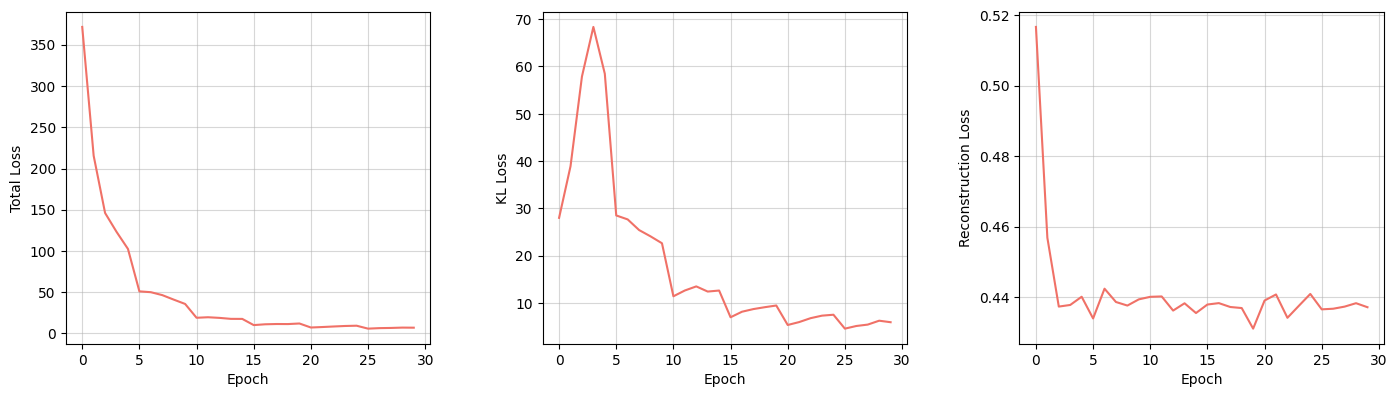

In [32]:
plot_results(history.history)


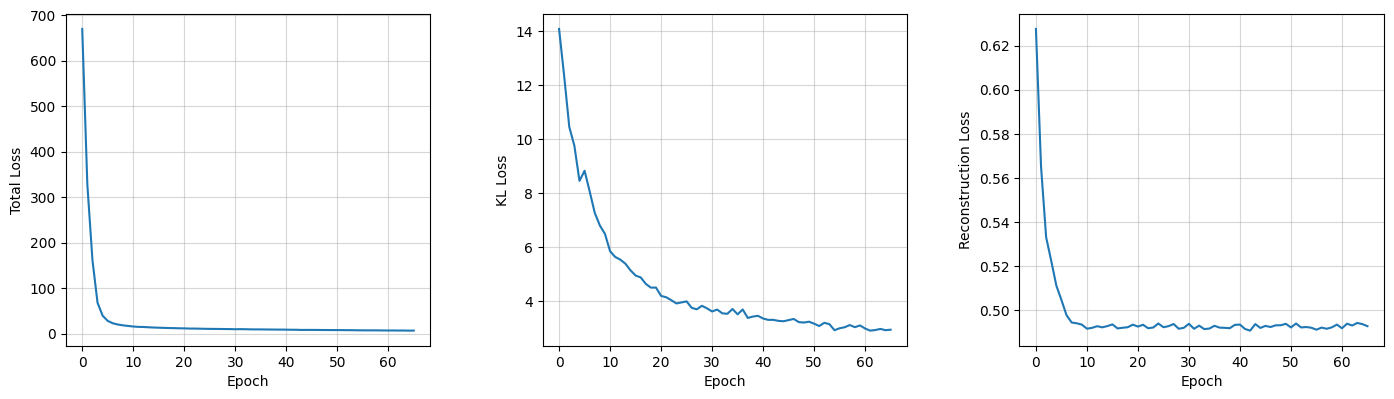

In [65]:
plot_results(dense_history)

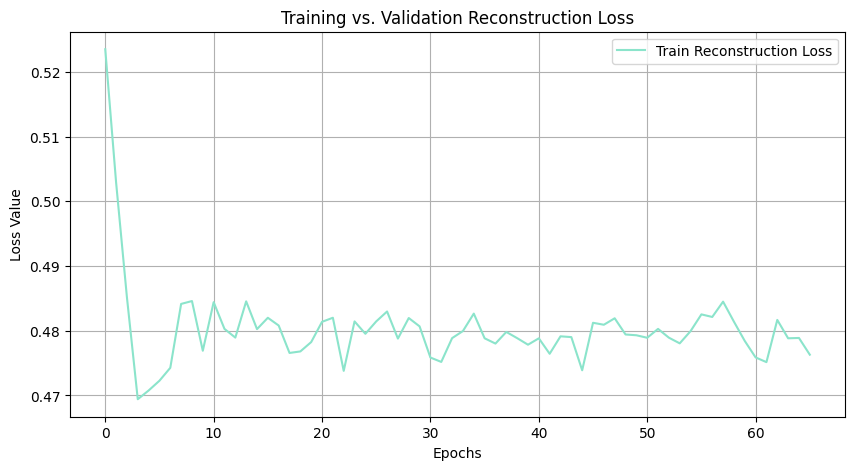

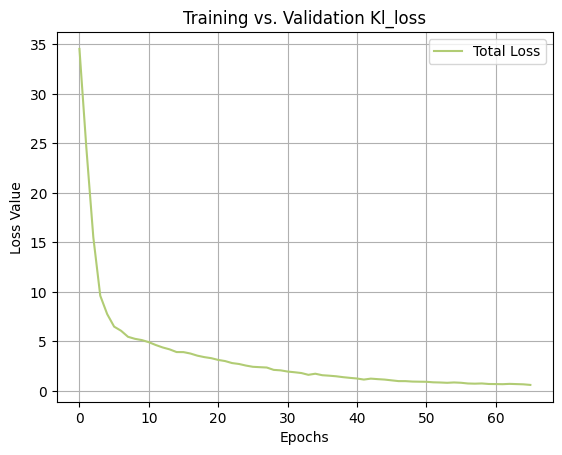

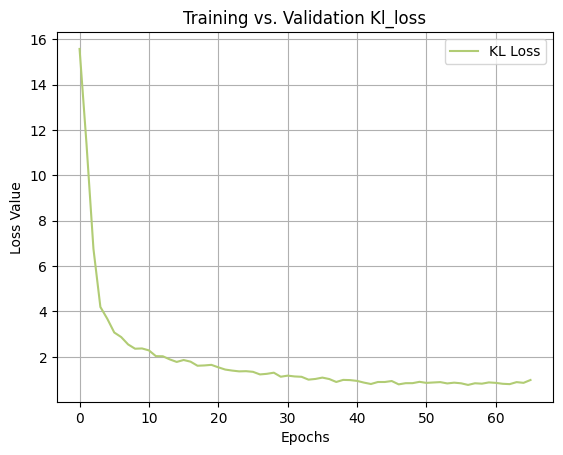

In [26]:
plot_training_vs_validation_loss(vae.history)


#Test

we pick time t1 = 60 and sample $z_{t_{1}}$ from $P_{b}(z_{t_{1}}|b_{t1})$.

In [ ]:
num_samples = 10
X_test = generate_sine_data(num_samples)

In [ ]:
t1 = 60
z_mean, z_log_var, z, bt = encoder(X_test) # z shape = (1,200,latent dim)
zt1 = z[:,t1,:] #(num_samples,latent dim)
np.shape(zt1)

TensorShape([10, 15])

Then we choose the a time interval $δ_{t} = [20,100]$ to skip, sample from the forward model $P(z_{2} | z_1, δ_{t})$ to obtain $z_{t_{2}}$ at $t_2 = t_1 +  δ_{t}$

In [ ]:
def sample_gaussian(z_mean, z_log_var):
    epsilon = tf.random.normal(shape=tf.shape(z_mean))
    return z_mean + tf.exp(0.5 * z_log_var) * epsilon


In [ ]:
def mse_loss(x,z):
  return (x-z)**2


In [ ]:
from tqdm import tqdm

def dense_layer(X_test,t1,zt1):
  loss = []
  for dt in tqdm(range(20,139)):
    #for i in range(num_samples):
    dt1 = tf.fill([tf.shape(zt1)[0], 1], tf.cast(dt, dtype=zt1.dtype))

    zt2_mean, zt2_log_var = transition(tf.concat([zt1, dt1], axis=-1))
    zt2 = sample_gaussian(zt2_mean, zt2_log_var)
      #my transition model doesnt sample so have to do it seperately

    xt2 = decoder(zt2)

    loss.append(np.mean(mse_loss(xt2, X_test[:,t1+dt])))



  return loss


def markov_prior(X_test,t1,zt1):
  trained_A = vae.A  # shape: (latent_dim,)
  trained_cov = vae.cov  # shape: (latent_dim,)
  loss = []
  for dt in tqdm(range(20,139)):
      zt2_mean = zt1 * tf.pow(trained_A, dt)  # element-wise multiplication
      zt2_log_var = tf.math.log(trained_cov)*A_poly(trained_A,dt-1)

      zt2 = sample_gaussian(zt2_mean, zt2_log_var)
      xt2 = decoder(zt2)
      loss.append(np.mean(mse_loss(xt2, X_test[:,t1+dt])))


  return loss






In [ ]:
markov_loss = markov_prior(X_test,t1,zt1)

100%|██████████| 119/119 [00:02<00:00, 45.87it/s]


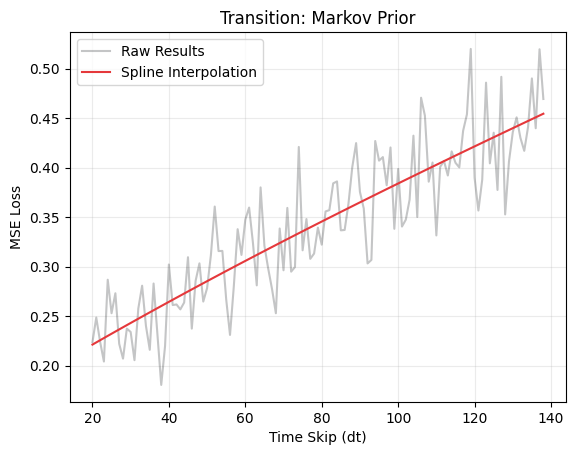

In [ ]:
from scipy.interpolate import UnivariateSpline
x = np.arange(20, len(markov_loss) + 20)
spline = UnivariateSpline(x, markov_loss, s=10)
markov_loss_smoothed = spline(x)

plt.plot(x, markov_loss, alpha = 0.25, color="#161a1d", label="Raw Results")
plt.plot(x, markov_loss_smoothed, color = "#e5383b", label="Spline Interpolation")
plt.grid(True, alpha=0.25)
plt.xlabel("Time Skip (dt)")
plt.ylabel("MSE Loss")
plt.title("Transition: Markov Prior")
plt.legend()
plt.show()

In [ ]:
dense_loss = dense_layer(X_test,t1,zt1)


100%|██████████| 119/119 [00:00<00:00, 147.92it/s]


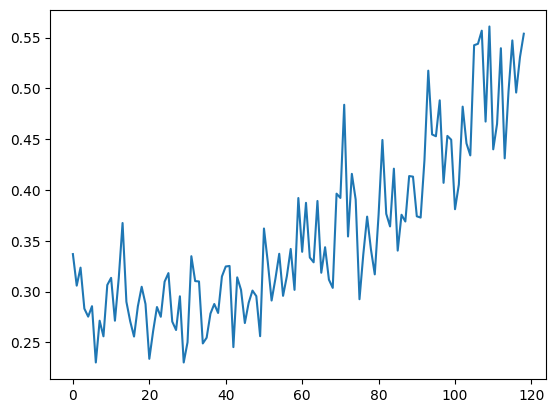

In [ ]:
plt.plot(dense_loss)

In [ ]:
# Generate Sample Preds

def markov_gen(X_test,t1,zt1):
  trained_A = vae.A  # shape: (latent_dim,)
  trained_cov = vae.cov  # shape: (latent_dim,)
  loss = []
  for dt in tqdm(range(20,139)):
      zt2_mean = zt1 * tf.pow(trained_A, dt)  # element-wise multiplication
      zt2_log_var = tf.math.log(trained_cov)*A_poly(trained_A,dt-1)

      zt2 = sample_gaussian(zt2_mean, zt2_log_var)
      xt2 = decoder(zt2)

  return xt2

preds_markov = markov_gen(X_test, t1, zt1)
preds_markov.shape


100%|██████████| 119/119 [00:03<00:00, 31.80it/s]


TensorShape([10, 1])

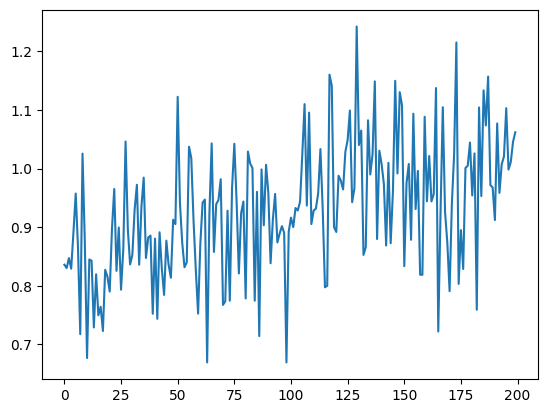

In [ ]:
plt.plot(X_test[0])